# Software Engineering Project - Titanic ML from Disaster
Jesse van der Merwe - 1829172

Robyn Gebbie - 2127777

https://www.kaggle.com/robynjesse

## Introduction
This notebook serves to document the code submitted for both the ELEN4009 exam and Titanic Machine Learning competition. 

The Titanic ML competition uses machine learning to create a model that predicts which passengers survived the Titanic shipwreck. 

The following steps will be taken: 
- Data analysis 
- Choice of ML
- ML Tuning
- Competition submisison 

## Imports and data input

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt


# testing and testing data input
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

## Analyzing the data

In [2]:
# Lets take a look at the data
print(train_df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

#### Column data analysis 
- PassengerId: ID of passenger
- Survived: Whether passenger survived or not (0=no, 1=yes)
- Pclass: Ticket class (1=1st/Upper, 2=2nd/Middle, 3=3rd/Lower)
- Name: Name of passenger
- Sex: Sex of passenger
- Age: Age of passenger (in years, fractional if less than 1)
- SibSp: Number of siblings/spouses aboard the Titanic 
- Parch: Number of parents/children aboard the Titanic 
- Ticket: Ticket number (mixed alphanumeric and numeric data type)
- Fare: Passenger fare
- Cabin: Cabin number (alphanumeric data type)
- Embarked: Port of embarkation (C=Cherbourg, Q=Queenstown, S=South Hampton)

In [3]:
# Categorization of the columns into three categories
all_columns = train_df.columns
categorical_columns = ['Survived', 'Pclass', 'Sex', 'Embarked']
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']
descriptive_columns = ['PassengerID', 'Name', 'Ticket', 'Cabin']

#### Description of the numerical and categorical columns

In [4]:
# Describe the categorical data
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
# Describe the numerical data
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### How many empty values are there in each column?
These empty cells need to be filled with suitable values. 

In [6]:
# Print the number of empty values for each column
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### What are the different data types of each column?
This is important because the final ML algorithms implemented will only accept numerical input. Therefore, identifying the values that need to be changed in order to figure out how to change them is important.  

It can be seen that 'Name', 'Sex', 'Ticket', 'Cabin' and 'Embarked fields are objects and therefore will need to be changed.

In [7]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### How many duplicate entries are there per column?
Duplicate entries could imply that the data is incorrect, especially if the column should be unique. Such columns include PassengerID, Name, Ticket and Cabin.

By printing the number of duplicate entries below, it can be seen that 'Ticket' has a high number of duplicates - this is concerning considering this should be a unique field. It was therefore decided that the 'Ticket' column could be ignored, as it would not provide useful data. 

The 'Cabin' field has an extremely high duplication rate.  

In [8]:
# Print the number of duplicate entries of columns that should be unique/almost unique
unique_columns = ["PassengerId", "Name", "Ticket", "Cabin"]
for i in range(0,len(unique_columns)):
    if len(unique_columns[i]) > 7:
        end = '\t'
    else:
        end = '\t\t'
    print(unique_columns[i], end=end)
    print(len(train_df[train_df.duplicated([unique_columns[i]], keep=False)]))

PassengerId	0
Name		0
Ticket		344
Cabin		790


#### Analysing the Cabin 
As mentioned above, the 'Cabin' column has a high rate of duplication. However, it should also be noted that there are also many missing cabin numbers. 


Interestingly, it can be seen that most passengers (70%) that do not have a cabin number, do not survive. It was therefore decided to extract the deck number (represented by the first letter of the 'Cabin' column) into a new column, and note each of the passengers with missing cabin (and therefore unknown deck numbers) with the same value. 

In [9]:
count_no_cabin_no_survive = 0
count_no_cabin_survive = 0
for i in range(len(train_df)):
    if type(train_df['Cabin'][i]) != str and train_df['Survived'][i] == 0:
        count_no_cabin_no_survive = count_no_cabin_no_survive + 1
    elif type(train_df['Cabin'][i]) != str and train_df['Survived'][i] == 1:
        count_no_cabin_survive = count_no_cabin_survive + 1
print(count_no_cabin_no_survive/(count_no_cabin_no_survive+count_no_cabin_survive)*100, end='')
print('% of passengers with no cabin number did not survive.')

70.01455604075691% of passengers with no cabin number did not survive.


## Data manipulation
#### Extract 'Title' from Name column 
Test 2: leaving the rare columns as is

In [10]:
# Lets start by extracting the title field (from both the training and testing data) so that Name column can be dropped
# If the title is less than 10% of the passengers, group it into "other"
for t in [train_df, test_df]:
    title = t.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    t['Title'] = title
    
print(train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())


       Title  Survived
0       Capt  0.000000
1        Col  0.500000
2   Countess  1.000000
3        Don  0.000000
4         Dr  0.428571
5   Jonkheer  0.000000
6       Lady  1.000000
7      Major  0.500000
8     Master  0.575000
9       Miss  0.697802
10      Mlle  1.000000
11       Mme  1.000000
12        Mr  0.156673
13       Mrs  0.792000
14        Ms  1.000000
15       Rev  0.000000
16       Sir  1.000000


#### Create a new column for 'Deck' value
We can also drop the 'Cabin' column after this

In [11]:
deck_array = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'] # Note -  there is a T deck, but only one entry
for t in [train_df, test_df]:
    t['Deck'] = deck_array.index('X')

for i in range(len(train_df)):
    if type(train_df['Cabin'][i]) == str:
        train_df['Deck'][i] = deck_array.index(train_df['Cabin'][i][0])

for i in range(len(test_df)):
    if type(test_df['Cabin'][i]) == str:
        test_df['Deck'][i] = deck_array.index(test_df['Cabin'][i][0])

print(train_df[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean())

train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

   Deck  Survived
0     0  0.466667
1     1  0.744681
2     2  0.593220
3     3  0.757576
4     4  0.750000
5     5  0.615385
6     6  0.500000
7     7  0.000000
8     8  0.299854


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


#### Remove 'Name', 'PassengerId', and 'Ticket' columns
As mentioned above, these columns do not correlate to the survival rate of the passengers.

In [12]:
# After extracting the Title field, we can drop the Name column
# We also want to drop the PassengerId, and Ticket columns as mentioned above
train_df = train_df.drop(['Name', 'PassengerId', 'Ticket'], axis=1)
test_df = test_df.drop(['Name', 'Ticket'], axis=1) # NB: We cannot drop PassengerId from test data yet as we need it for the final submission


#### Combining SibSp and Parch
Since SibSp contains both siblings and spouses, and Parch contains both parents and children, there is no useful way of using this data (for example to decide whether the person has children and therefore must be an adult, but they could also have parents and therefore be young in age).

We will instead combine these two columns into one 'NumRelatives' column. 

If the passenger was alone, this might increase or decrease their chance of survival. Therefore by using the new 'NumRelatives' column we can easily create a new column to describe whether the passenger was alone or not.

Use 1=alone, 0=not alone.

In [13]:
for t in [train_df, test_df]:
    t['NumRelatives'] = t['SibSp'] + t['Parch']
    t.loc[t['NumRelatives'] > 0, 'Alone'] = 0
    t.loc[t['NumRelatives'] == 0, 'Alone'] = 1
    t['Alone'] = t['Alone'].astype(int)
print(train_df[['NumRelatives', 'Survived']].groupby(['NumRelatives'], as_index=False).mean())
print(train_df[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean())

train_df = train_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)


   NumRelatives  Survived
0             0  0.303538
1             1  0.552795
2             2  0.578431
3             3  0.724138
4             4  0.200000
5             5  0.136364
6             6  0.333333
7             7  0.000000
8            10  0.000000
   Alone  Survived
0      0  0.505650
1      1  0.303538


#### Calculate missing age values 
By using the title's average age group. 
- By plotting Title, Age, and Survived, we see that most titles band Age groups accurately. 
- A random number between the title's average age plus and minus that title's standard deviation. 
- By generating a random number between the one standard deviation up and down from the average age value, we will be able to populate the 'Other' title values. 


In [14]:
average_ages_per_title = train_df[['Title', 'Age']].groupby(['Title'], as_index=False).mean()
std_dev_per_title = train_df[['Title', 'Age']].groupby(['Title'], as_index=False).std()
average = train_df['Age'].mean()
standard_deviation = test_df['Age'].std()

print(std_dev_per_title)

for i in range(len(train_df)):
    if math.isnan(train_df['Age'][i]):
        # if(train_df['Title'][i] == 'Other'):
        #     rand_age = np.random.randint(average - standard_deviation, average + standard_deviation)
        #     train_df['Age'][i] = rand_age
        # else:
        for j in range(len(average_ages_per_title)):
            if train_df['Title'][i] == average_ages_per_title['Title'][j]:
                if(not math.isnan(std_dev_per_title['Age'][j])):
                    rand_age_title = np.random.randint(average_ages_per_title['Age'][j] - std_dev_per_title['Age'][j], average_ages_per_title['Age'][j] + std_dev_per_title['Age'][j])
                    train_df['Age'][i] = rand_age_title
                else:
                    train_df['Age'][i] = average_ages_per_title['Age'][j]

for i in range(len(test_df)):
    if math.isnan(test_df['Age'][i]):
        # if(test_df['Title'][i] == 'Other'):
        #     rand_age = np.random.randint(average - standard_deviation, average + standard_deviation)
        #     test_df['Age'][i] = rand_age
        # else:
        for j in range(len(average_ages_per_title)):
            if test_df['Title'][i] == average_ages_per_title['Title'][j]:
                if(not math.isnan(std_dev_per_title['Age'][j])):
                    rand_age_title = np.random.randint(average_ages_per_title['Age'][j] - std_dev_per_title['Age'][j], average_ages_per_title['Age'][j] + std_dev_per_title['Age'][j])
                    test_df['Age'][i] = rand_age_title
                else:
                    test_df['Age'][i] = average_ages_per_title['Age'][j]

train_df['Age'] = train_df['Age'].astype(int)
test_df['Age'] = test_df['Age'].astype(int)

print(train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean())

       Title        Age
0       Capt        NaN
1        Col   2.828427
2   Countess        NaN
3        Don        NaN
4         Dr  12.016655
5   Jonkheer        NaN
6       Lady        NaN
7      Major   4.949747
8     Master   3.619872
9       Miss  12.990292
10      Mlle   0.000000
11       Mme        NaN
12        Mr  12.708793
13       Mrs  11.433628
14        Ms        NaN
15       Rev  13.136463
16       Sir        NaN
    Age  Survived
0     0  0.875000
1     1  0.714286
2     2  0.300000
3     3  0.833333
4     4  0.700000
..  ...       ...
66   66  0.000000
67   70  0.000000
68   71  0.000000
69   74  0.000000
70   80  1.000000

[71 rows x 2 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Calculate missing Embarked values
Since there are only two missing embark values (<1%), we will just fill these values with the most common Embark location: S
It should be noted that the test data is not missing any Embark values.

In [15]:
train_df['Embarked'].describe()
train_df['Embarked'].fillna('S', inplace=True)

#### Convert 'Fare' individual values to grouped data 
Binning helps deal with outliers

In [16]:
# <12.5th percentile = 0
# <25th percentile = 1
# <37.5th percentile = 2
# <50th percentile = 3
# <62.5th percentile = 4 
# <75th percentile = 5
# <87.5th percentile = 6 
# <100th percentile = 7

percentile = np.quantile(train_df['Fare'], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
print(percentile)

for i in range(len(train_df['Fare'])):
    if train_df['Fare'][i] <= percentile[0]:
        train_df['Fare'][i] = 0
    elif train_df['Fare'][i] <= percentile[1]:
        train_df['Fare'][i] = 1
    elif train_df['Fare'][i] <= percentile[2]:
        train_df['Fare'][i] = 2
    elif train_df['Fare'][i] <= percentile[3]:
        train_df['Fare'][i] = 3
    elif train_df['Fare'][i] <= percentile[4]:
        train_df['Fare'][i] = 4
    elif train_df['Fare'][i] <= percentile[5]:
        train_df['Fare'][i] = 5
    elif train_df['Fare'][i] <= percentile[6]:
        train_df['Fare'][i] = 6
    elif train_df['Fare'][i] <= percentile[7]:
        train_df['Fare'][i] = 7

print(train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean())

# Fill in the two missing fare values with the average fare value
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

for i in range(len(test_df['Fare'])):
    if test_df['Fare'][i] <= percentile[0]:
        test_df['Fare'][i] = 0
    elif test_df['Fare'][i] <= percentile[1]:
        test_df['Fare'][i] = 1
    elif test_df['Fare'][i] <= percentile[2]:
        test_df['Fare'][i] = 2
    elif test_df['Fare'][i] <= percentile[3]:
        test_df['Fare'][i] = 3
    elif test_df['Fare'][i] <= percentile[4]:
        test_df['Fare'][i] = 4
    elif test_df['Fare'][i] <= percentile[5]:
        test_df['Fare'][i] = 5
    elif test_df['Fare'][i] <= percentile[6]:
        test_df['Fare'][i] = 6
    elif test_df['Fare'][i] <= percentile[7]:
        test_df['Fare'][i] = 7

[  7.75       7.9104     9.84065   14.4542    24.479175  31.
  69.4875   512.3292  ]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: Settin

   Fare  Survived
0   0.0  0.207143
1   1.0  0.180723
2   2.0  0.198198
3   3.0  0.407080
4   4.0  0.436364
5   5.0  0.473214
6   6.0  0.481818
7   7.0  0.678571


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to b

#### Convert 'Age' individual values to grouped data 
Binning helps deal with outliers

In [17]:
# <12.5th percentile = 0
# <25th percentile = 1
# <37.5th percentile = 2
# <50th percentile = 3
# <62.5th percentile = 4 
# <75th percentile = 5
# <87.5th percentile = 6 
# <100th percentile = 7

percentile_age = np.quantile(train_df['Age'], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
for i in range(len(train_df['Age'])):
    if train_df['Age'][i] <= percentile_age[0]:
        train_df['Age'][i] = 0
    elif train_df['Age'][i] <= percentile_age[1]:
        train_df['Age'][i] = 1
    elif train_df['Age'][i] <= percentile_age[2]:
        train_df['Age'][i] = 2
    elif train_df['Age'][i] <= percentile_age[3]:
        train_df['Age'][i] = 3
    elif train_df['Age'][i] <= percentile_age[4]:
        train_df['Age'][i] = 4
    elif train_df['Age'][i] <= percentile_age[5]:
        train_df['Age'][i] = 5
    elif train_df['Age'][i] <= percentile_age[6]:
        train_df['Age'][i] = 6
    elif train_df['Age'][i] <= percentile_age[7]:
        train_df['Age'][i] = 7

# print(train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean())

for i in range(len(test_df['Age'])):
    if test_df['Age'][i] <= percentile_age[0]:
        test_df['Age'][i] = 0
    elif test_df['Age'][i] <= percentile_age[1]:
        test_df['Age'][i] = 1
    elif test_df['Age'][i] <= percentile_age[2]:
        test_df['Age'][i] = 2
    elif test_df['Age'][i] <= percentile_age[3]:
        test_df['Age'][i] = 3
    elif test_df['Age'][i] <= percentile_age[4]:
        test_df['Age'][i] = 4
    elif test_df['Age'][i] <= percentile_age[5]:
        test_df['Age'][i] = 5
    elif test_df['Age'][i] <= percentile_age[6]:
        test_df['Age'][i] = 6
    elif test_df['Age'][i] <= percentile_age[7]:
        test_df['Age'][i] = 7

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarn

#### RESULTING DATA EXTRACTED: 
- Title: extracted from the Name column
- NumRelatives: extracted by combining SibSp and Parch 
- Deck: extracted from the first letter of Cabin's

#### RESULTING ASSUMPTIONS FOR EACH COLUMN: 
- PassengerId: dropped - no correlation to survival
- Pclass: correlates to survival
- Name: dropped - no correlation to survival without too complicated algorithms 
- Sex: correlates to survival, needs to be converted to number set
- Age: correlates to survival, many missing values - needs to be completed
- SibSp: dropped - too vague to correlate to survival without further complicated analysis
- Parch: dropped - too vague to correlate to survival without further complicated analysis
- Ticket: dropped - no correlation to survival, and high rate of duplication
- Fare: converted into bands for better dealing of outliers
- Cabin: dropped - no correlation to survival, and high rate of duplication and many missing values 
- Embarked: correlates to survival, needs to be completed

## Convert Categorical Column Values to Numerical Values
#### Convert 'S', 'C' and 'Q' to numerical values for analysis

In [18]:
cherbourg = 1 # C=1
queenstown = 2 # Q=2
southhampton = 3# S=3

for i in range(len(train_df)):
    if train_df['Embarked'][i] == 'C':
        train_df['Embarked'][i] = cherbourg
    elif train_df['Embarked'][i] == 'Q':
        train_df['Embarked'][i] = queenstown    
    elif train_df['Embarked'][i] == 'S':
        train_df['Embarked'][i] = southhampton

print(train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

for i in range(len(test_df)):
    if test_df['Embarked'][i] == 'C':
        test_df['Embarked'][i] = cherbourg
    elif test_df['Embarked'][i] == 'Q':
        test_df['Embarked'][i] = queenstown    
    elif test_df['Embarked'][i] == 'S':
        test_df['Embarked'][i] = southhampton

   Embarked  Survived
0         1  0.553571
1         2  0.389610
2         3  0.339009


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib

#### Convert 'Titles' to numerical values for analysis

In [19]:
# print(titles_updated)
# for i in range(len(train_df)):
#     for j in range(0, len(titles_updated)):
#         if train_df['Title'][i] == titles_updated[j]:
#             train_df['Title'][i] = j

# print(train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

# for i in range(len(test_df)):
#     for j in range(len(titles_updated)):
#         if test_df['Title'][i] == titles_updated[j]:
#             test_df['Title'][i] = j

title_array = train_df['Title'].unique()
print(title_array)
for i in range(len(train_df)):
    for j in range(0, len(title_array)):
        if train_df['Title'][i] == title_array[j]:
            train_df['Title'][i] = j

print(train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

title_array_test = test_df['Title'].unique()
for i in range(len(test_df)):
    for j in range(len(title_array_test)):
        if test_df['Title'][i] == title_array_test[j]:
            test_df['Title'][i] = j

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


    Title  Survived
0       0  0.156673
1       1  0.792000
2       2  0.697802
3       3  0.575000
4       4  0.000000
5       5  0.000000
6       6  0.428571
7       7  1.000000
8       8  1.000000
9       9  0.500000
10     10  1.000000
11     11  1.000000
12     12  1.000000
13     13  0.500000
14     14  0.000000
15     15  1.000000
16     16  0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Convert 'Sex' to numerical values for analysis

In [20]:
for i in range(len(train_df)):
    if train_df['Sex'][i] == 'female':
        train_df['Sex'][i] = 0
    elif train_df['Sex'][i] == 'male':
        train_df['Sex'][i] = 1

print(train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

for i in range(len(test_df)):
    if test_df['Sex'][i] == 'female':
        test_df['Sex'][i] = 0
    elif test_df['Sex'][i] == 'male':
        test_df['Sex'][i] = 1

   Sex  Survived
0    0  0.742038
1    1  0.188908


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/con

#### Fill in all blank values of test_db with 0

## Final Data Display

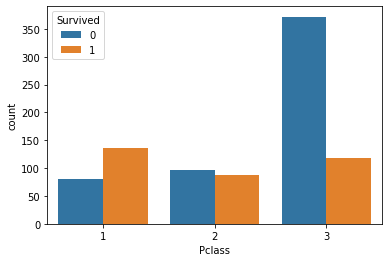

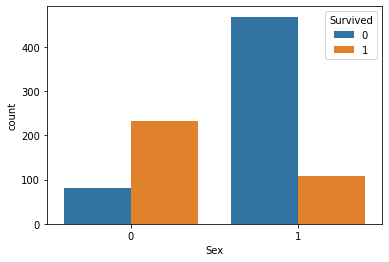

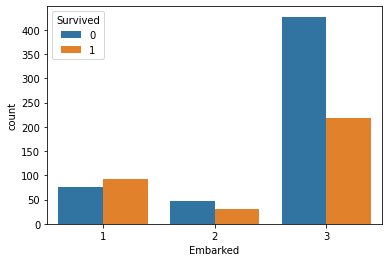

In [21]:
cols = categorical_columns

for i in range(0, len(cols)):
    if(cols[i] != 'Survived'):
        sns.countplot(x=train_df[cols[i]], hue=train_df["Survived"])
        plt.show()

## Machine Learning Algorithm Implementation

In [22]:
train_x = train_df.drop("Survived", axis=1)
train_y = train_df["Survived"]
test_x  = test_df.drop("PassengerId", axis=1).copy()
train_x.shape, train_y.shape, test_x.shape

((891, 9), (891,), (418, 9))

#### Logistic Regression

In [23]:
logistic_regression = LogisticRegression()
logistic_regression.fit(train_x, train_y)
prediction_lr = logistic_regression.predict(test_x)
accuracy_lr = round(logistic_regression.score(train_x, train_y) * 100, 4)
accuracy_lr

80.0224

#### KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_x, train_y)
prediction_knn = knn.predict(test_x)
accuracy_knn = round(knn.score(train_x, train_y) * 100, 4)
accuracy_knn

86.6442

Gaussian Naive Bayes

In [25]:
gaussian = GaussianNB()
gaussian.fit(train_x, train_y)
prediction_gauss = gaussian.predict(test_x)
accuracy_gauss = round(gaussian.score(train_x, train_y) * 100, 4)
accuracy_gauss

77.2166

MLP

In [26]:
mlp_classification = MLPClassifier() 
mlp_classification.fit(train_x, train_y)
prediction_mlp = mlp_classification.predict(test_x)
accuracy_mlp = round(mlp_classification.score(train_x, train_y) * 100, 4)
accuracy_mlp

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


84.624

## Logistic Regression Tuning

#### Split Up Training Data

In [27]:
## Should only testing data be used and data split? 

#### Grid Search Method

In [28]:
parameters = {
    'solver':  ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'C': [0.001, 0.05, 0.1, 0.5, 1, 10, 100, 1000],
    'max_iter': [100, 200, 300, 400, 500, 600]
}
clf = GridSearchCV(logistic_regression, parameters, n_jobs=-1, cv=3)
clf.fit(train_x, train_y)

print('Best parameters according to Grid Search: \n', clf.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best parameters according to Grid Search: 
 {'C': 0.5, 'max_iter': 200, 'solver': 'saga'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


#### Random Search Method

In [29]:
parameters = {
    'C': sp_randInt(0.001, 100),
    'max_iter': sp_randInt(100, 1000)
}

clf = RandomizedSearchCV(logistic_regression, parameters, n_jobs=-1, cv=10)
clf.fit(train_x, train_y)

print('Best parameters according to Randomized Search: \n', clf.best_params_)

Best parameters according to Randomized Search: 
 {'C': 64, 'max_iter': 732}


#### Training and Validation Accuracy Curves 

##### Hyperparameter C

Text(0.5, 1.0, 'Training and Validation Accuracy')

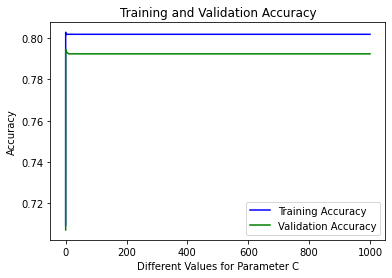

In [30]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

c_values = [0.001, 0.05, 0.1, 0.5, 1, 10, 100, 1000]

# different values for C, inverse of regularization strength, minimises model's overfitting, if model is more complex regularization will reduce the error due to variance
# penalty: type of regularization
# solver: algorithm used for optimization: 'liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'
# max_iter

train_results, validation_results = validation_curve(pipeline, train_x, train_y, cv = 10, param_name = 'logisticregression__C', param_range = c_values, scoring = "accuracy")

train_results_mean = np.mean(train_results, axis = 1)
validation_results_mean = np.mean(validation_results, axis = 1)

plt.plot(c_values, train_results_mean, color='blue', label='Training Accuracy')
plt.plot(c_values, validation_results_mean, color='green', label='Validation Accuracy')
plt.xlabel('Different Values for Parameter C')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

##### Hyperparameter Solver

Text(0.5, 1.0, 'Training and Validation Accuracy')

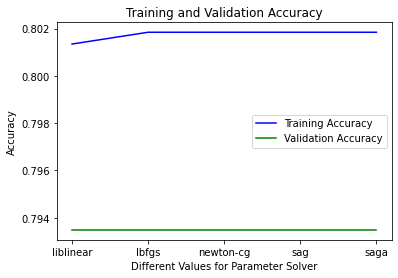

In [31]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

solver_values = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']

train_results, validation_results = validation_curve(pipeline, train_x, train_y, cv = 10, param_name = 'logisticregression__solver', param_range = solver_values, scoring = "accuracy")

train_results_mean = np.mean(train_results, axis = 1)
validation_results_mean = np.mean(validation_results, axis = 1)

plt.plot(solver_values, train_results_mean, color='blue', label='Training Accuracy')
plt.plot(solver_values, validation_results_mean, color='green', label='Validation Accuracy')
plt.xlabel('Different Values for Parameter Solver')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

##### Hyperparameter max_iter

Text(0.5, 1.0, 'Training and Validation Accuracy')

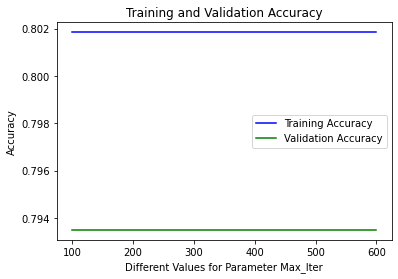

In [32]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

max_iter_values =  [100, 200, 300, 400, 500, 600]

train_results, validation_results = validation_curve(pipeline, train_x, train_y, cv = 10, param_name = 'logisticregression__max_iter', param_range = max_iter_values, scoring = "accuracy")

train_results_mean = np.mean(train_results, axis = 1)
validation_results_mean = np.mean(validation_results, axis = 1)

plt.plot(max_iter_values , train_results_mean, color='blue', label='Training Accuracy')
plt.plot(max_iter_values , validation_results_mean, color='green', label='Validation Accuracy')
plt.xlabel('Different Values for Parameter Max_Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

#### Training and Validation Loss Curves

##### Hyperparameter C

Text(0.5, 1.0, 'Training and Validation Loss Curve')

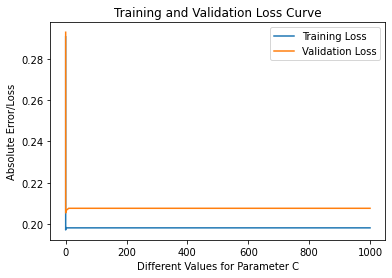

In [33]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

c_values = [0.001, 0.05, 0.1, 0.5, 1, 10, 100, 1000] # play around with these values for better graph

train_results, validation_results = validation_curve(pipeline, train_x, train_y, cv = 10, param_name = 'logisticregression__C', param_range = c_values, scoring="accuracy")

train_errors_mean = 1-np.mean(train_results, axis = 1) # convert accuracy to misclassification rate (ie loss)
validation_errors_mean = 1-np.mean(validation_results , axis = 1)


plt.plot(c_values, train_errors_mean, label="Training Loss")
plt.plot(c_values, validation_errors_mean, label="Validation Loss")
plt.legend()

plt.xlabel('Different Values for Parameter C')
plt.ylabel('Absolute Error/Loss')
plt.title('Training and Validation Loss Curve')

##### Hyperparameter Solver

Text(0.5, 1.0, 'Training and Validation Loss Curve')

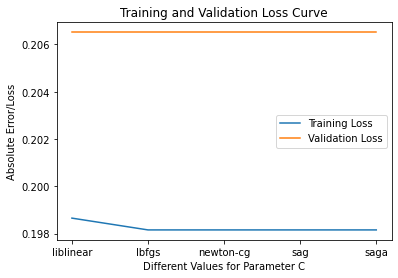

In [34]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

solver_values = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']# play around with these values for better graph

train_results, validation_results = validation_curve(pipeline, train_x, train_y, cv = 10, param_name = 'logisticregression__solver', param_range = solver_values, scoring="accuracy")

train_errors_mean = 1-np.mean(train_results, axis = 1) # convert accuracy to misclassification rate (ie loss)
validation_errors_mean = 1-np.mean(validation_results , axis = 1)


plt.plot(solver_values, train_errors_mean, label="Training Loss")
plt.plot(solver_values, validation_errors_mean, label="Validation Loss")
plt.legend()

plt.xlabel('Different Values for Parameter C')
plt.ylabel('Absolute Error/Loss')
plt.title('Training and Validation Loss Curve')

##### Hyperparameter max_iter

Text(0.5, 1.0, 'Training and Validation Loss Curve')

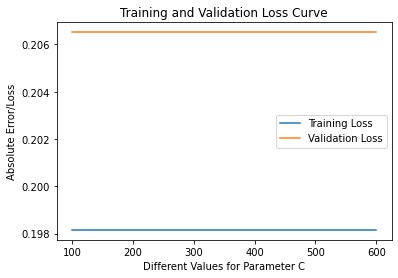

In [35]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())

max_iter_values =  [100, 200, 300, 400, 500, 600]# play around with these values for better graph

train_results, validation_results = validation_curve(pipeline, train_x, train_y, cv = 10, param_name = 'logisticregression__max_iter', param_range = max_iter_values, scoring="accuracy")

train_errors_mean = 1-np.mean(train_results, axis = 1) # convert accuracy to misclassification rate (ie loss)
validation_errors_mean = 1-np.mean(validation_results , axis = 1)


plt.plot(max_iter_values, train_errors_mean, label="Training Loss")
plt.plot(max_iter_values, validation_errors_mean, label="Validation Loss")
plt.legend()

plt.xlabel('Different Values for Parameter C')
plt.ylabel('Absolute Error/Loss')
plt.title('Training and Validation Loss Curve')

#### Cross Validation

##### K-Fold Cross Validation for More Accurate Error Estimation

In [36]:
def cross_validation(logistic_regression, param):
    kf = KFold(n_splits = 5)
    results = cross_val_score(logistic_regression, train_x, train_y, cv = kf)  # iterates and splits up data for you
    error = 1 - results.mean()
    print('Avg error for ' + str(param) +': ' + format(error))
    return error


#### Training Error For Logistic Regression Using Cross Validation

##### Hyperparameter C

Avg error for 0.001: 0.30076580252338203
Avg error for 0.05: 0.2188374866612265
Avg error for 0.1: 0.21433682756889083
Avg error for 0.5: 0.2076266398845018
Avg error for 1: 0.2098612767560103
Avg error for 10: 0.20873768125039227
Avg error for 100: 0.20762036281463803
Avg error for 1000: 0.20762036281463803


Text(0.5, 1.0, 'Training and Validation Error Curve')

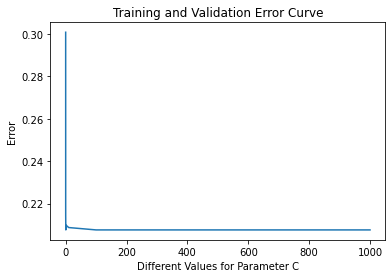

In [37]:
errors = []
c_values = [0.001, 0.05, 0.1, 0.5, 1, 10, 100, 1000] 
for x in range(8):
    logistic_regression = LogisticRegression(C = c_values[x])
    error = cross_validation(logistic_regression, c_values[x])
    errors.append(error)

plt.plot(c_values, errors)
plt.xlabel('Different Values for Parameter C')
plt.ylabel('Error')
plt.title('Training and Validation Error Curve')

##### Hyperparameter Solver

Avg error for liblinear: 0.20986755382587408
Avg error for lbfgs: 0.2098612767560103
Avg error for newton-cg: 0.2098612767560103


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Avg error for sag: 0.21211474483711013
Avg error for saga: 0.20875023539011983


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Text(0.5, 1.0, 'Training and Validation Error Curve')

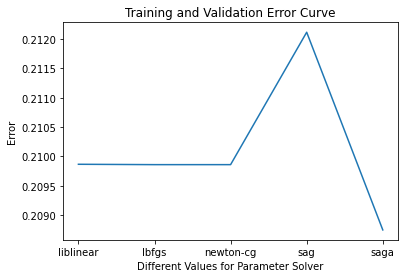

In [38]:
errors = []
solver_values =  ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
for x in range(5):
    logistic_regression = LogisticRegression(solver = solver_values[x])
    error = cross_validation(logistic_regression, solver_values[x])
    errors.append(error)

plt.plot(solver_values, errors)
plt.xlabel('Different Values for Parameter Solver')
plt.ylabel('Error')
plt.title('Training and Validation Error Curve')

##### Hyperparameter max_iter

Avg error for 100: 0.2098612767560103
Avg error for 200: 0.2098612767560103
Avg error for 300: 0.2098612767560103
Avg error for 400: 0.2098612767560103
Avg error for 500: 0.2098612767560103
Avg error for 600: 0.2098612767560103


Text(0.5, 1.0, 'Training and Validation Error Curve')

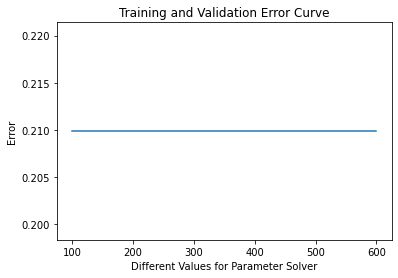

In [39]:
errors = []
max_iter_values =  [100, 200, 300, 400, 500, 600]
for x in range(6):
    logistic_regression = LogisticRegression(max_iter = max_iter_values[x])
    error = cross_validation(logistic_regression, max_iter_values[x])
    errors.append(error)

plt.plot(max_iter_values, errors)
plt.xlabel('Different Values for Parameter Solver')
plt.ylabel('Error')
plt.title('Training and Validation Error Curve')

Calculate the most accurate method

In [40]:
prediction_array = [prediction_lr, prediction_knn, prediction_gauss, prediction_mlp]
accuracy_array = [accuracy_lr, accuracy_knn, accuracy_gauss, accuracy_mlp]
model_names_array = ['Logistic Regression', 'KNN', 'Gaussian NB', 'MLP']

print('MODEL', end = '\t\t\t')
print('ACCURACY')
for i in range(0, len(prediction_array)):
    if len(model_names_array[i]) > 14:
        end = '\t'
    elif len(model_names_array[i]) > 7:
        end = '\t\t'
    else:
        end = '\t\t\t'
    print(model_names_array[i], end = end)
    print(accuracy_array[i])
    
# max_accuracy = max(accuracy_array)
# max_index = accuracy_array.index(max_accuracy)
print()
# print("SUBMITTED MODEL: ", end='')
# print(model_names_array[max_index])

# submission = pd.DataFrame({
#         "PassengerId": test_df["PassengerId"],
#         "Survived": prediction_array[max_index]
#     })
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": prediction_lr
    })

submission.to_csv('./submission.csv', index=False)

MODEL			ACCURACY
Logistic Regression	80.0224
KNN			86.6442
Gaussian NB		77.2166
MLP			84.624

